# 0. Importing Libraries

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn import preprocessing
import copy

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


%matplotlib inline

# 1. Data Visualization and Dealing with missing values

In [3]:
dat_train = pd.read_csv('Data\\aug_train.csv')
dat_test = pd.read_csv('Data\\aug_test.csv')

In [4]:
dat_train


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


<AxesSubplot: >

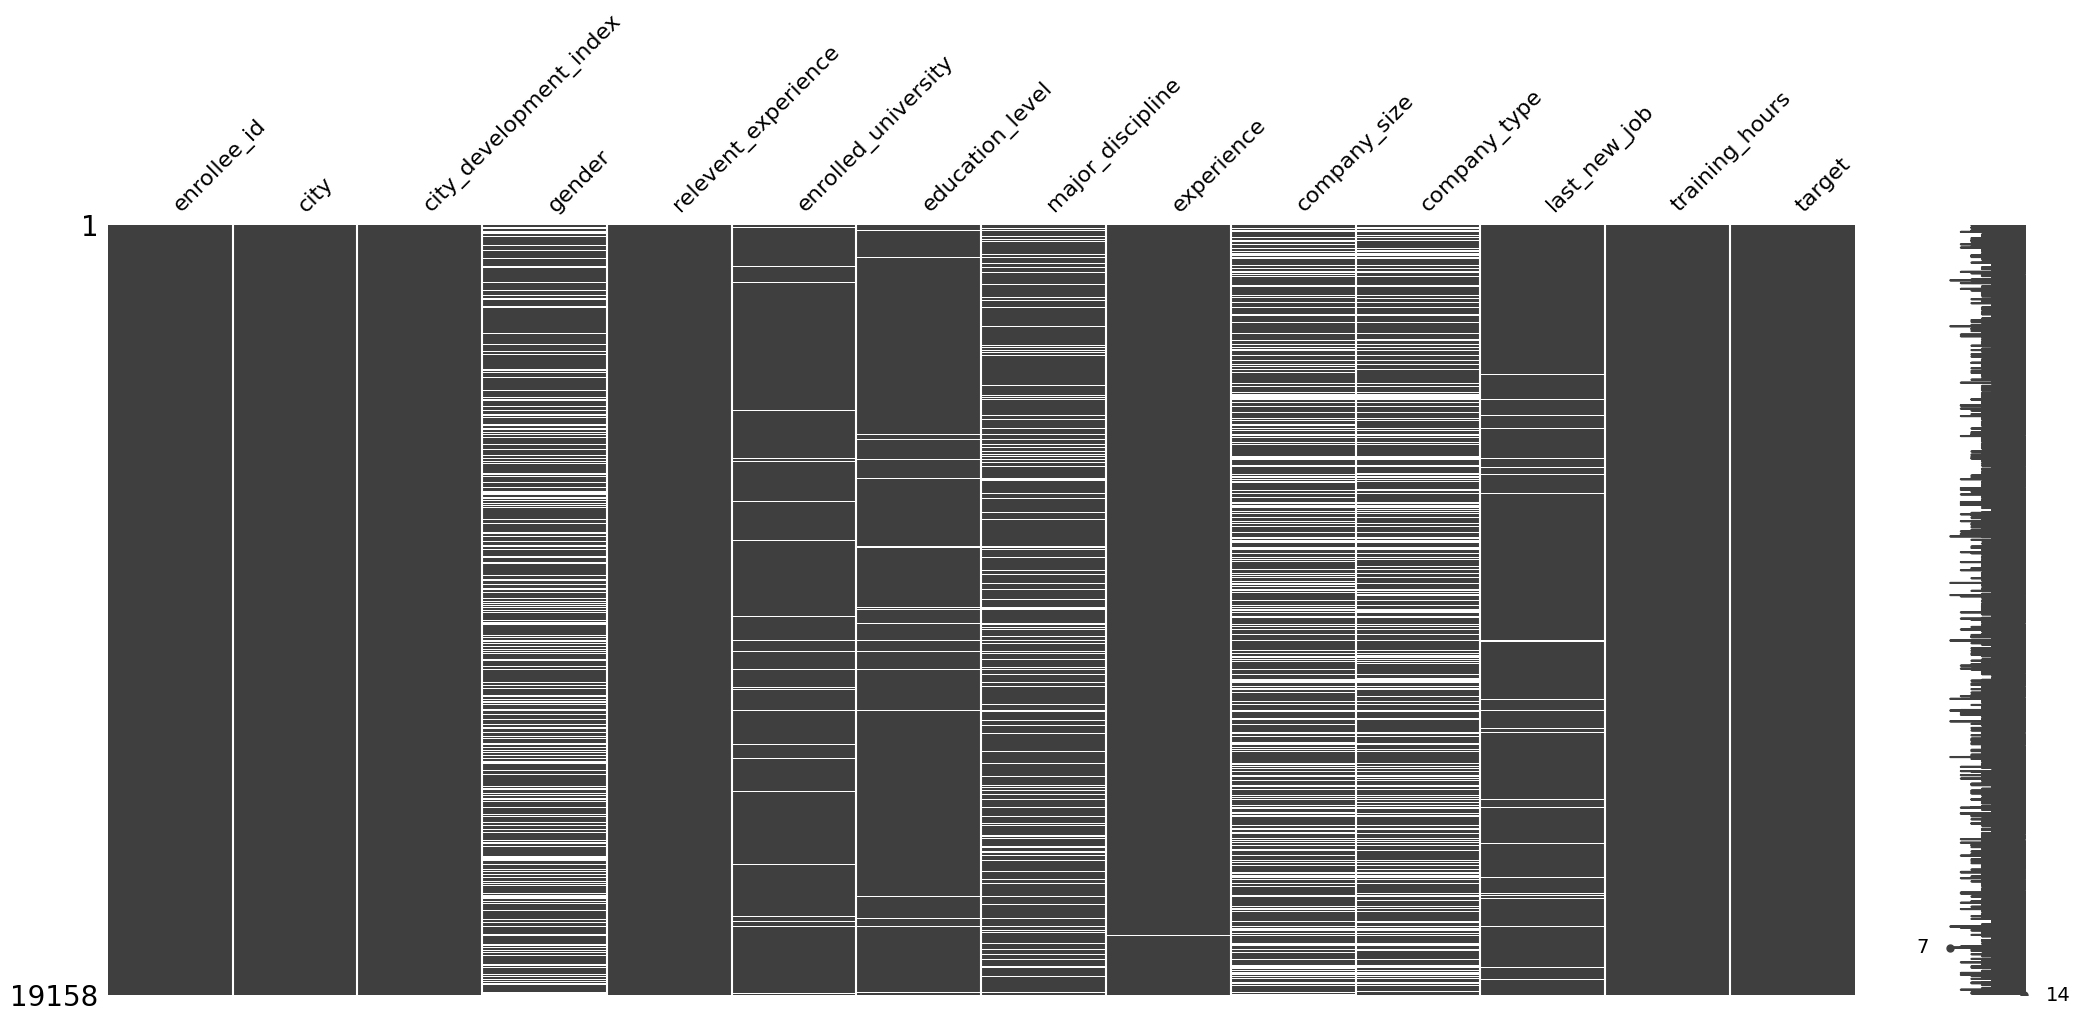

In [5]:
msno.matrix(dat_train)

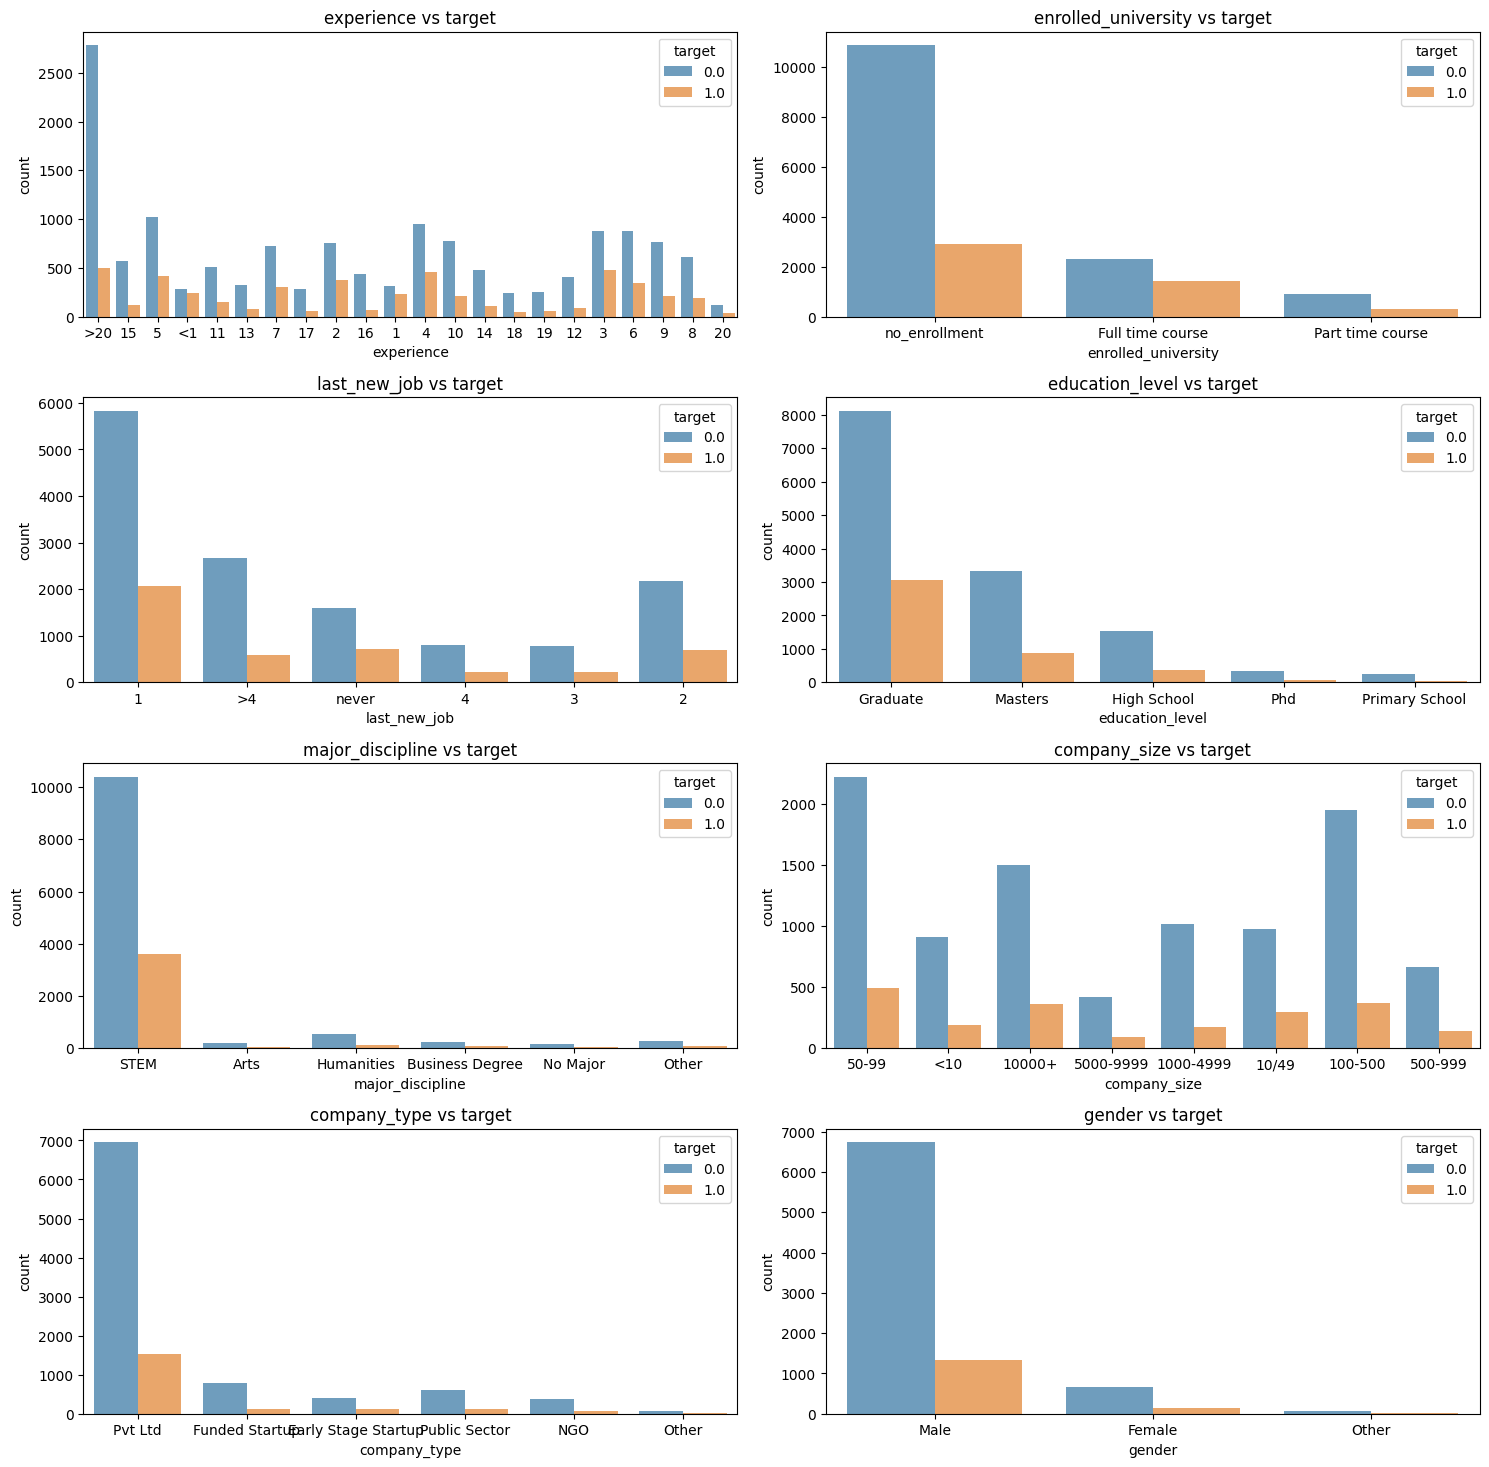

In [6]:
features = [
    "experience", "enrolled_university", "last_new_job", "education_level", "major_discipline", "company_size", "company_type", "gender"
]
count = 0
n = 1

plt.figure(figsize=[15, 18])

for feature in features:
    plt.subplot(5, 2, n)
    sns.countplot(x=feature, hue='target', alpha=0.7, data=dat_train)
    plt.title("{} vs target".format(feature))
    n = n+1
    
    if count < 3:
        dat_train.dropna(subset=[feature], inplace=True)
    else:
        dat_train[feature].fillna(
            method='ffill', limit=3, inplace=True)
        dat_train.dropna(subset=[feature], inplace=True)

plt.tight_layout()
plt.show()


<AxesSubplot: >

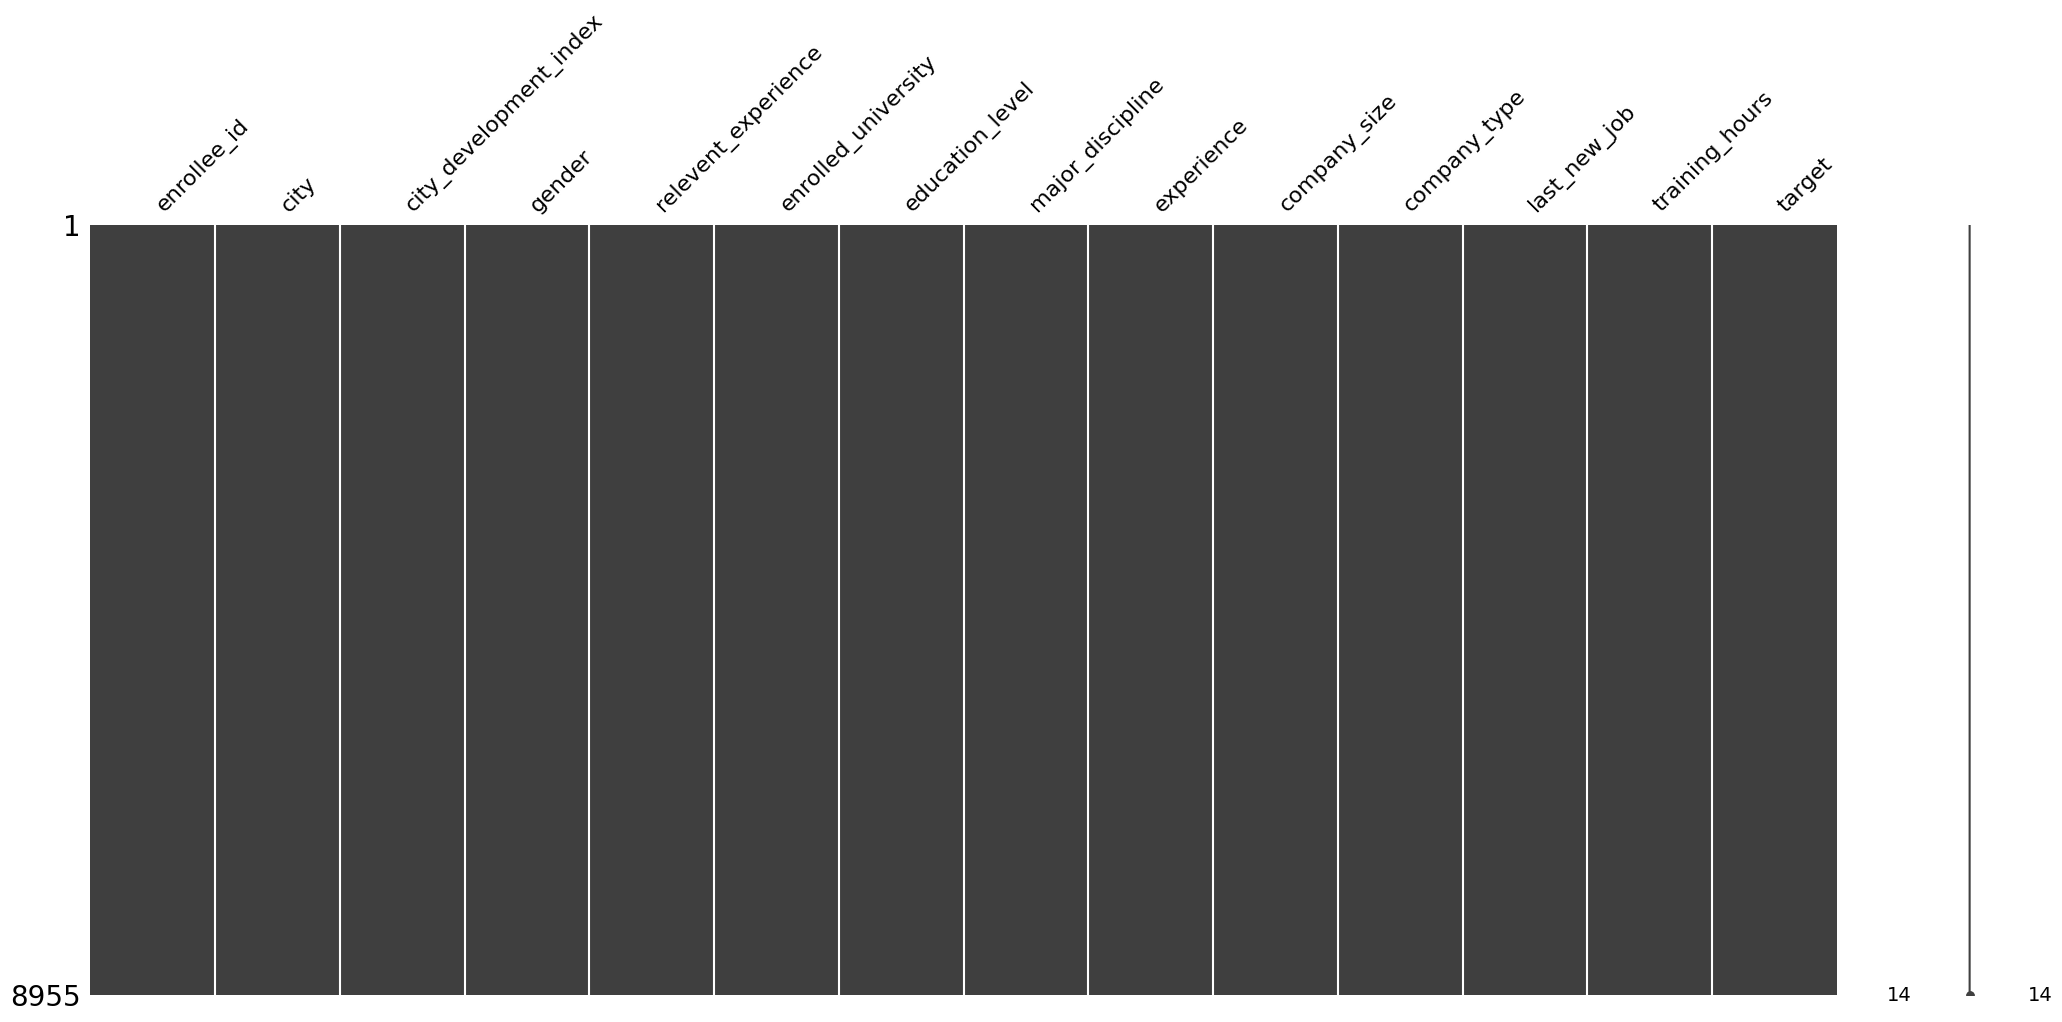

In [7]:
msno.matrix(dat_train)

In [8]:
x=dat_train.groupby(['target'])['target'].count()
print(x)

target
0.0    7472
1.0    1483
Name: target, dtype: int64


<AxesSubplot: xlabel='target', ylabel='count'>

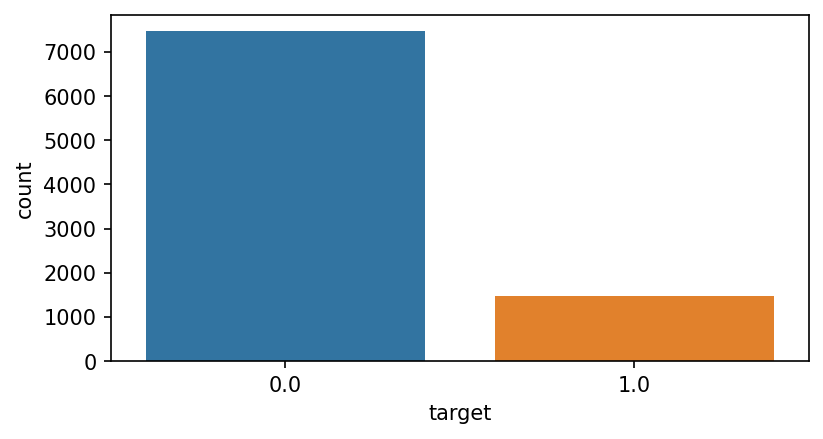

In [9]:
plt.figure(figsize=(6,3),dpi=150)
sns.countplot(data=dat_train,x='target')

# 3. Handling Imbalance in Data

In [10]:
df_train = copy.deepcopy(dat_train)
df_test=copy.deepcopy(dat_test)

In [11]:
dat_train

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0
8,27107,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,46,1.0
11,23853,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,5000-9999,Pvt Ltd,1,108,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19147,21319,city_21,0.624,Male,No relevent experience,Full time course,Graduate,STEM,1,100-500,Pvt Ltd,1,52,1.0
19149,251,city_103,0.920,Male,Has relevent experience,no_enrollment,Masters,STEM,9,50-99,Pvt Ltd,1,36,1.0
19150,32313,city_160,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,10,100-500,Public Sector,3,23,0.0
19152,29754,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,Humanities,7,10/49,Funded Startup,1,25,0.0


In [12]:
le = preprocessing.LabelEncoder()

df_data_encorded = dat_train[['city', 'gender', 'relevent_experience', 'enrolled_university', 'major_discipline', 'education_level', 'experience',
                     'company_size', 'company_type', 'last_new_job']].apply(
    le.fit_transform)

df_data_numerical = dat_train[[
    'city_development_index', 'training_hours', 'target']]

In [13]:
df_data = pd.concat([df_data_encorded, df_data_numerical], axis=1)

In [14]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8955 entries, 1 to 19155
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    8955 non-null   int32  
 1   gender                  8955 non-null   int32  
 2   relevent_experience     8955 non-null   int32  
 3   enrolled_university     8955 non-null   int32  
 4   major_discipline        8955 non-null   int32  
 5   education_level         8955 non-null   int32  
 6   experience              8955 non-null   int32  
 7   company_size            8955 non-null   int32  
 8   company_type            8955 non-null   int32  
 9   last_new_job            8955 non-null   int32  
 10  city_development_index  8955 non-null   float64
 11  training_hours          8955 non-null   int64  
 12  target                  8955 non-null   float64
dtypes: float64(2), int32(10), int64(1)
memory usage: 629.6 KB


In [15]:
ftrain = ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level',
          'company_size', 'company_type', 'city_development_index', 'training_hours', 'target']

def Definedata():
    datcpy = df_data[ftrain]
    
    X = datcpy.drop(columns=['target']).values
    y = datcpy['target'].values
    
    return X, y


In [16]:
def SMOTEs():

    X, y = Definedata()

    counter = Counter(y)
    print(counter)
    
    smt = SMOTE(random_state=0)
    
    X, y = smt.fit_resample(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=2)
    
    counter = Counter(y)
    print(counter)
    
    return X_train, X_test, y_train, y_test


In [17]:
X_train, X_test, y_train, y_test = SMOTEs()

Counter({0.0: 7472, 1.0: 1483})
Counter({0.0: 7472, 1.0: 7472})


# 4. Model Comparison

In [19]:
result = []

In [20]:
XGB = XGBClassifier(max_depth = 1)
XGB.fit(X_train, y_train)

y_pred_xgb = XGB.predict(X_test)

cm_xgb = confusion_matrix(y_pred_xgb, y_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

result.append(acc_xgb)
print("RESULT")
print("XGBoost Model Acc : ",acc_xgb)
print("The condusion Matrix of XGBoost")
print(cm_xgb)
print(classification_report(y_test, y_pred_xgb))

RESULT
XGBoost Model Acc :  0.8436739659367397
The condusion Matrix of XGBoost
[[2251  568]
 [ 203 1910]]
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.85      2454
         1.0       0.90      0.77      0.83      2478

    accuracy                           0.84      4932
   macro avg       0.85      0.84      0.84      4932
weighted avg       0.85      0.84      0.84      4932



In [22]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
  

y_pred_NaiveBayes = gnb.predict(X_test)

cm_NaiveBayes = confusion_matrix(y_pred_NaiveBayes, y_test)

acc_NaiveBayes= accuracy_score(y_test, y_pred_NaiveBayes)

result.append(acc_NaiveBayes)
print("RESULT")
print("NaiveBayes Model Acc : ",acc_NaiveBayes)
print("The confusion Matrix of NaiveBayes")
print(cm_NaiveBayes)
print(classification_report(y_test, y_pred_NaiveBayes))

RESULT
NaiveBayes Model Acc :  0.7210056772100568
The confusion Matrix of NaiveBayes
[[1973  895]
 [ 481 1583]]
              precision    recall  f1-score   support

         0.0       0.69      0.80      0.74      2454
         1.0       0.77      0.64      0.70      2478

    accuracy                           0.72      4932
   macro avg       0.73      0.72      0.72      4932
weighted avg       0.73      0.72      0.72      4932



In [24]:

clf = DecisionTreeClassifier(criterion="entropy")

clf = clf.fit(X_train,y_train)

y_pred_DT = clf.predict(X_test)

cm_DT = confusion_matrix(y_pred_DT, y_test)

acc_DT= accuracy_score(y_test, y_pred_DT)

result.append(acc_DT)
print("RESULT")
print("Decision Tree Model Acc : ",acc_DT)
print("The confusion Matrix of Decision Tree")
print(cm_DT)
print(classification_report(y_test, y_pred_DT))

RESULT
Decision Tree Model Acc :  0.845904298459043
The confusion Matrix of Decision Tree
[[2090  396]
 [ 364 2082]]
              precision    recall  f1-score   support

         0.0       0.84      0.85      0.85      2454
         1.0       0.85      0.84      0.85      2478

    accuracy                           0.85      4932
   macro avg       0.85      0.85      0.85      4932
weighted avg       0.85      0.85      0.85      4932



In [25]:
classifier_rf = RandomForestClassifier(random_state=42)

classifier_rf.fit(X_train, y_train)

y_pred_rf = classifier_rf.predict(X_test)

cm_rf = confusion_matrix(y_pred_DT, y_test)

acc_rf= accuracy_score(y_test, y_pred_rf)

result.append(acc_rf)
print("RESULT")
print("Random Forest Model Acc : ",acc_rf)
print("The confusion Matrix of Random Forest")
print(cm_rf)
print(classification_report(y_test, y_pred_rf))

NameError: name 'RandomForestClassifier' is not defined

In [30]:
svm_model = SVC(kernel='linear', random_state=0, C=1.0)
    
svm_model.fit(X_train,y_train)

y_pred_svm = Svm_model.predict(X_test)

cm_svm = confusion_matrix(y_pred_svm, y_test)

acc_svm= accuracy_score(y_test, y_pred_svm)

result.append(acc_svm)
print("RESULT")
print("SVM Acc : ",acc_svm)
print("The confusion Matrix of SVM")
print(cm_svm)
print(classification_report(y_test, y_pred_svm))